In [129]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import GraphRicciCurvature
%matplotlib inline

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from GraphRicciCurvature.OllivierRicci import OllivierRicci

Загрузка данных.

In [130]:
file_path = "/Users/natalabereberdina/dip/arxiv_embeddings_10000.csv"
df = pd.read_csv(file_path)

x_train = np.array([np.fromstring(emb[1:-1], sep=",") for emb in df["embedding"]])
y_train = df["categories"]

In [131]:
print(type(x_train[0]), len(x_train), len(x_train[0]))

X = np.zeros((len(x_train), len(x_train[0])))
for i in range(len(x_train)):
    X[i] = np.array(x_train[i])
df = pd.DataFrame(X)
df["label"] = pd.DataFrame(y_train)

<class 'numpy.ndarray'> 10000 1536


Вспомогательные функции.

In [132]:
from visual_and_stats_func import two_counts_gist, two_visualisation_target_colors, show_results, graph_main_info
from dist_func import calculate_and_save_distances, build_investments_dist
from surgery import simple_surgery, another_surgery
from build_graph_func import (
    find_treshhold,
    get_random_sample,
    remove_degree_zero_nodes_efficient,
    table_by_graph,
    get_indices,
    get_indices_from_top_label,
)

Начало эксперимента.

In [133]:
indices = get_indices_from_top_label(x_train, y_train, 5, 100)

Распределение классов в выборке: Counter({'cs.AI': 30, 'cs.CV': 30, 'cs.LG stat.ML': 24, 'cs.LG': 10, 'cs.CL': 6})


In [134]:
calculate_and_save_distances(x_train, indices, filename="mnist_dist_sample.csv", metric="mse")
threshold = find_treshhold("mnist_dist_sample.csv", indices, rule="avg")
(x_test, y_test, graph_MNIST) = get_random_sample("mnist_dist_sample.csv", x_train, y_train, indices, threshold)

threshold =  0.00030276730229879706


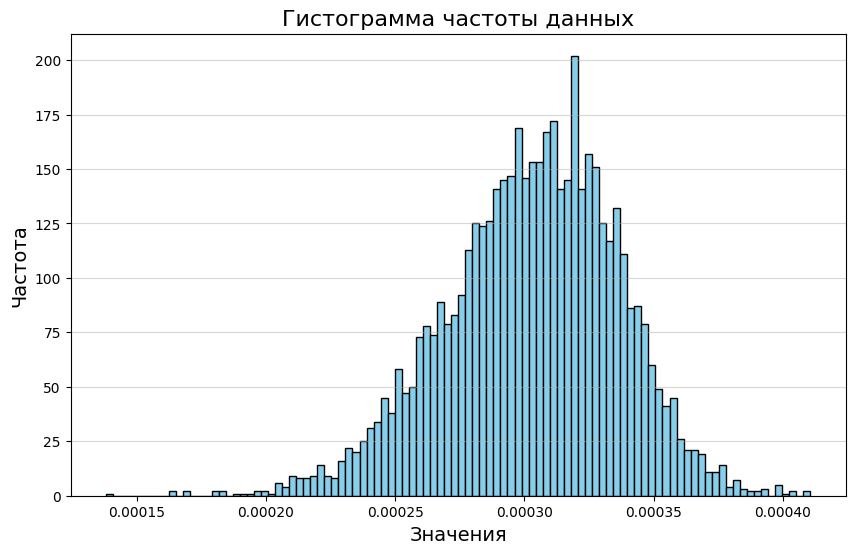

In [135]:
build_investments_dist(filename="mnist_dist_sample.csv", indices=indices)

In [136]:
graph_main_info(graph_MNIST)

counts = Counter(y_test)
sorted_counts = [counts[key] for key in sorted(counts.keys())]
print(sorted_counts)

Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
[30, 6, 30, 10, 24]


Удаляем вершины нулевой степени.

In [137]:
graph_MNIST = remove_degree_zero_nodes_efficient(graph_MNIST)
df_graph = table_by_graph(df, graph_MNIST)[1]

graph_main_info(graph_MNIST)
counts_non_zero = Counter(df_graph["label"])
sorted_counts_non_zero = [counts_non_zero[key] for key in sorted(counts_non_zero.keys())]
print(sorted_counts_non_zero)

Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
[30, 6, 30, 10, 24]


In [138]:
graph_MNIST.nodes

NodeView(('[0.004874754697084427, 0.012842132709920406, 0.005925842560827732, -0.02076571434736252, -0.022409724071621895, 0.0006527185905724764, -0.012653475627303123, -0.004595138598233461, -0.00421782536432147, -0.04616699367761612, 0.0352788083255291, 0.02870277315378189, 0.01774720661342144, 0.012276162393391132, 0.006293049082159996, -0.011299190111458302, 0.023056546226143837, 0.029457399621605873, -0.011319403536617756, -0.004089808091521263, -0.02083309181034565, -0.0014940937981009483, -0.026681451126933098, -0.020240170881152153, -0.0034244563430547714, 0.007579957600682974, 0.021439488977193832, -0.038485970348119736, -0.010288529098033905, -0.012303113006055355, 0.019135180860757828, 0.021169979125261307, -0.03686891496181488, 0.01804366707801819, 0.00623240927234292, 0.0019371001981198788, 0.009453048929572105, -0.015308145433664322, 0.021223880350589752, -0.022342346608638763, 0.02899923361837864, 0.033446140587329865, 0.0058685713447630405, -0.014162729494273663, 0.0254

Вычисляем кривизну Риччи и поток Риччи.

TRACE:Number of nodes: 100
TRACE:Number of edges: 2349
TRACE:Start to compute all pair shortest path.
TRACE:0.005418 secs for all pair by NetworKit.
INFO:0.316149 secs for Ricci curvature computation.


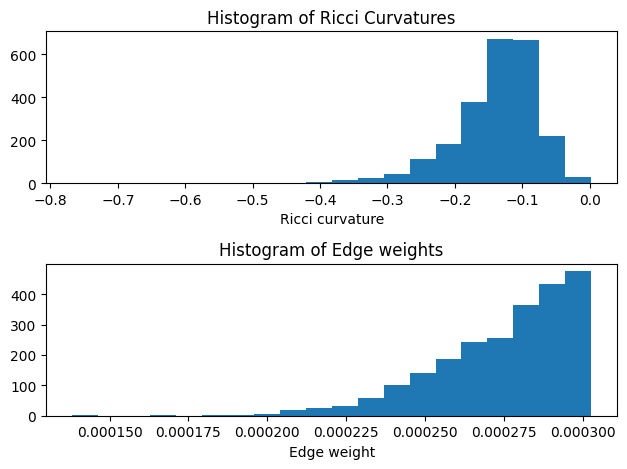

In [139]:
orc = OllivierRicci(graph_MNIST, alpha=0.5, method="ATD", verbose="TRACE")
orc.compute_ricci_curvature()
G = orc.G.copy()
show_results(G)

Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1


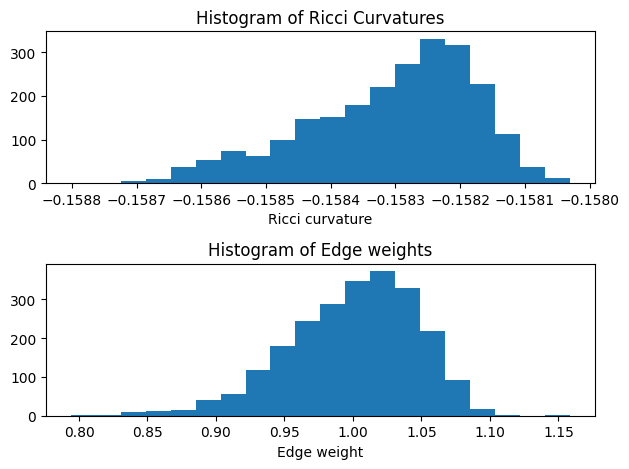

In [140]:
orc.set_verbose("ERROR")
orc.compute_ricci_flow(iterations=10)
G_rf = orc.G.copy()
show_results(G_rf)
graph_main_info(G_rf)

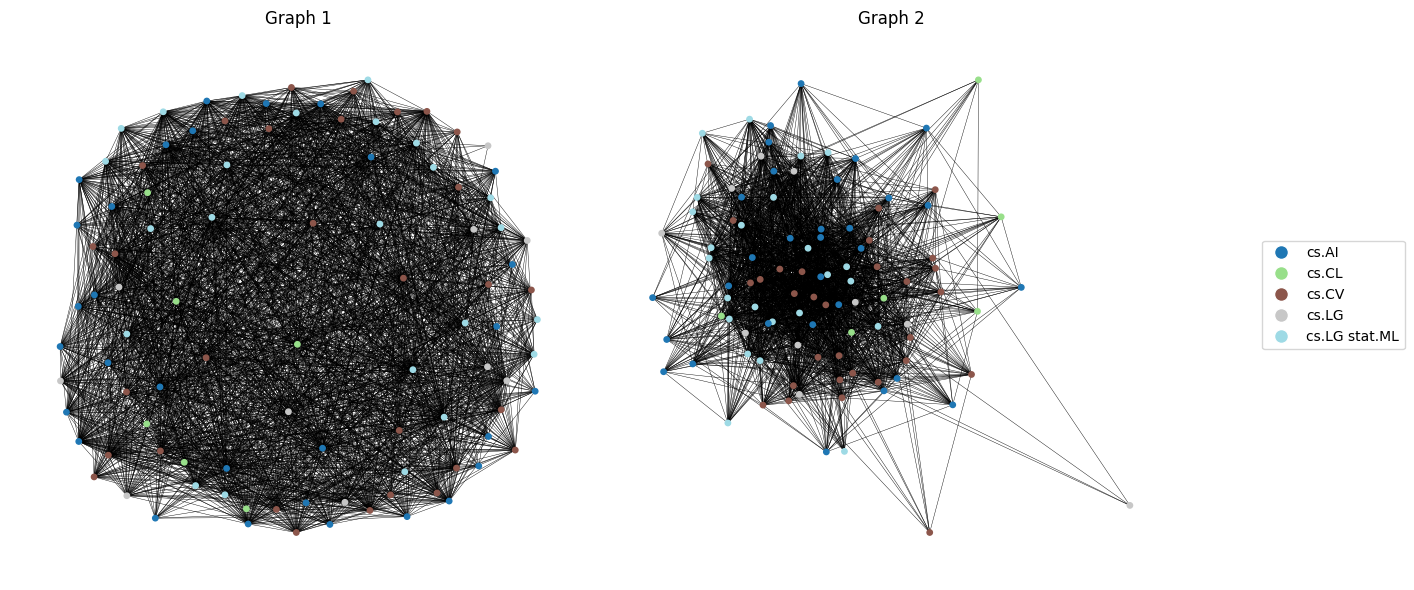

In [141]:
two_visualisation_target_colors(G, G_rf, iteration_spring=10, legend=True)

После подсчета Риччи флоу мы удаляем ребра с большим весом с помощью simple_surgery.

another_surgery - моя функция, которая наоборот удаляет ребра с маленьким весом.

In [142]:
orc.set_verbose("ERROR")
orc.compute_ricci_flow(iterations=1)
G_rf = orc.G.copy()

In [143]:
G_rf_1 = simple_surgery(G_rf, cut=1.05)
G_rf_2 = simple_surgery(G_rf, cut=0.95)

Сравниваем графы после simple_surgery и another_surgery

In [144]:
graph_main_info(G_rf_1)
graph_main_info(G_rf_2)

Количество вершин в графе: 100
Количество ребер в графе: 2029
Количество компонент связности: 1
Количество вершин в графе: 100
Количество ребер в графе: 347
Количество компонент связности: 28


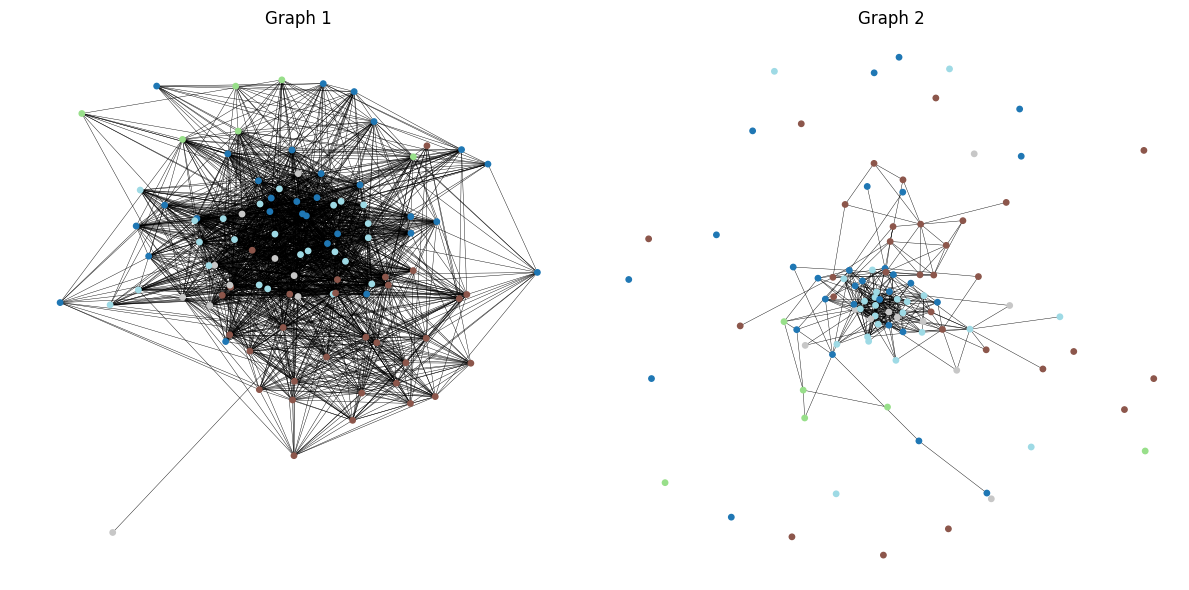

In [145]:
two_visualisation_target_colors(G_rf_1, G_rf_2, iteration_spring=10)

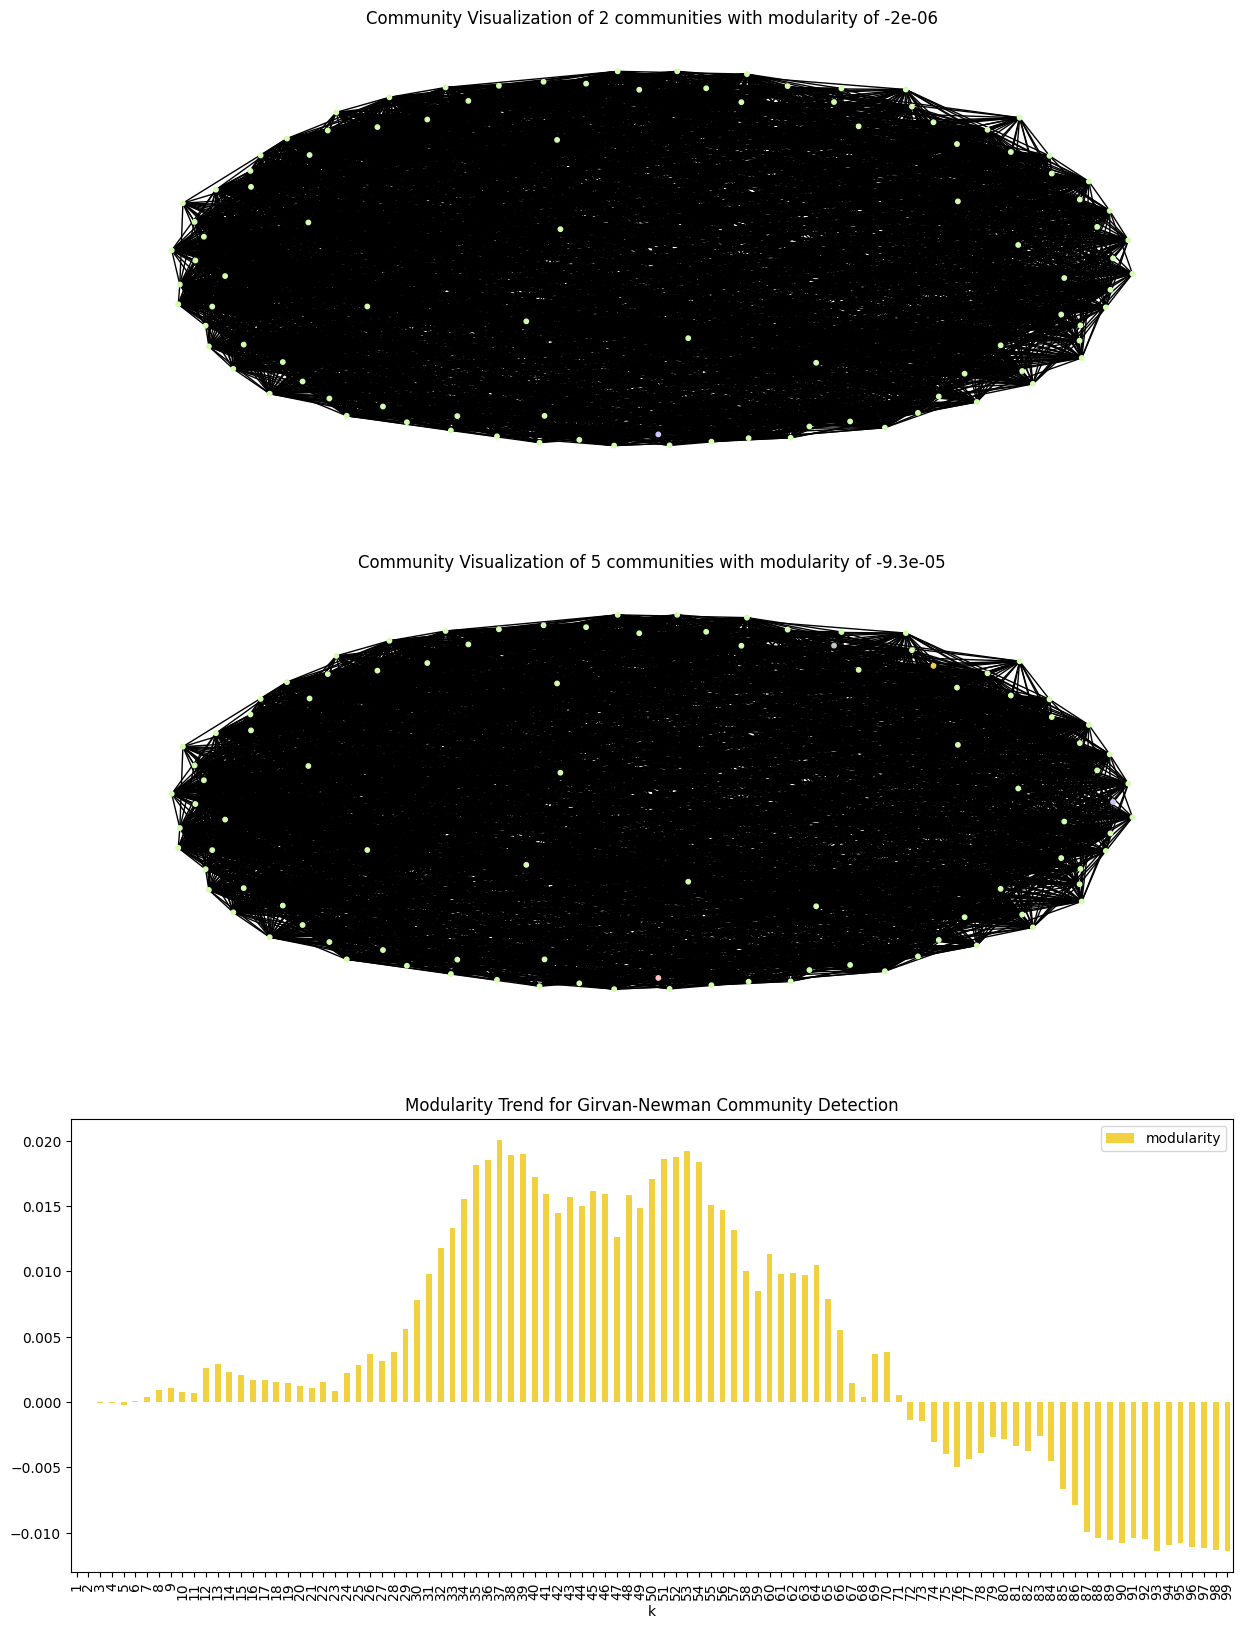

In [146]:
# Community Visualization of 2 communities with modularity of 0.34766, Community Visualization of 5 communities with modularity of 0.384972, Modularity Trend for Girvan-Newman Community Detection

import matplotlib.pyplot as plt

# Load karate graph and find communities using Girvan-Newman
G = G
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [[k + 1, nx.community.modularity(G, communities[k])] for k in range(len(communities))],
    columns=["k", "modularity"],
)


# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities)
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=10,
        node_color=node_colors,
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()

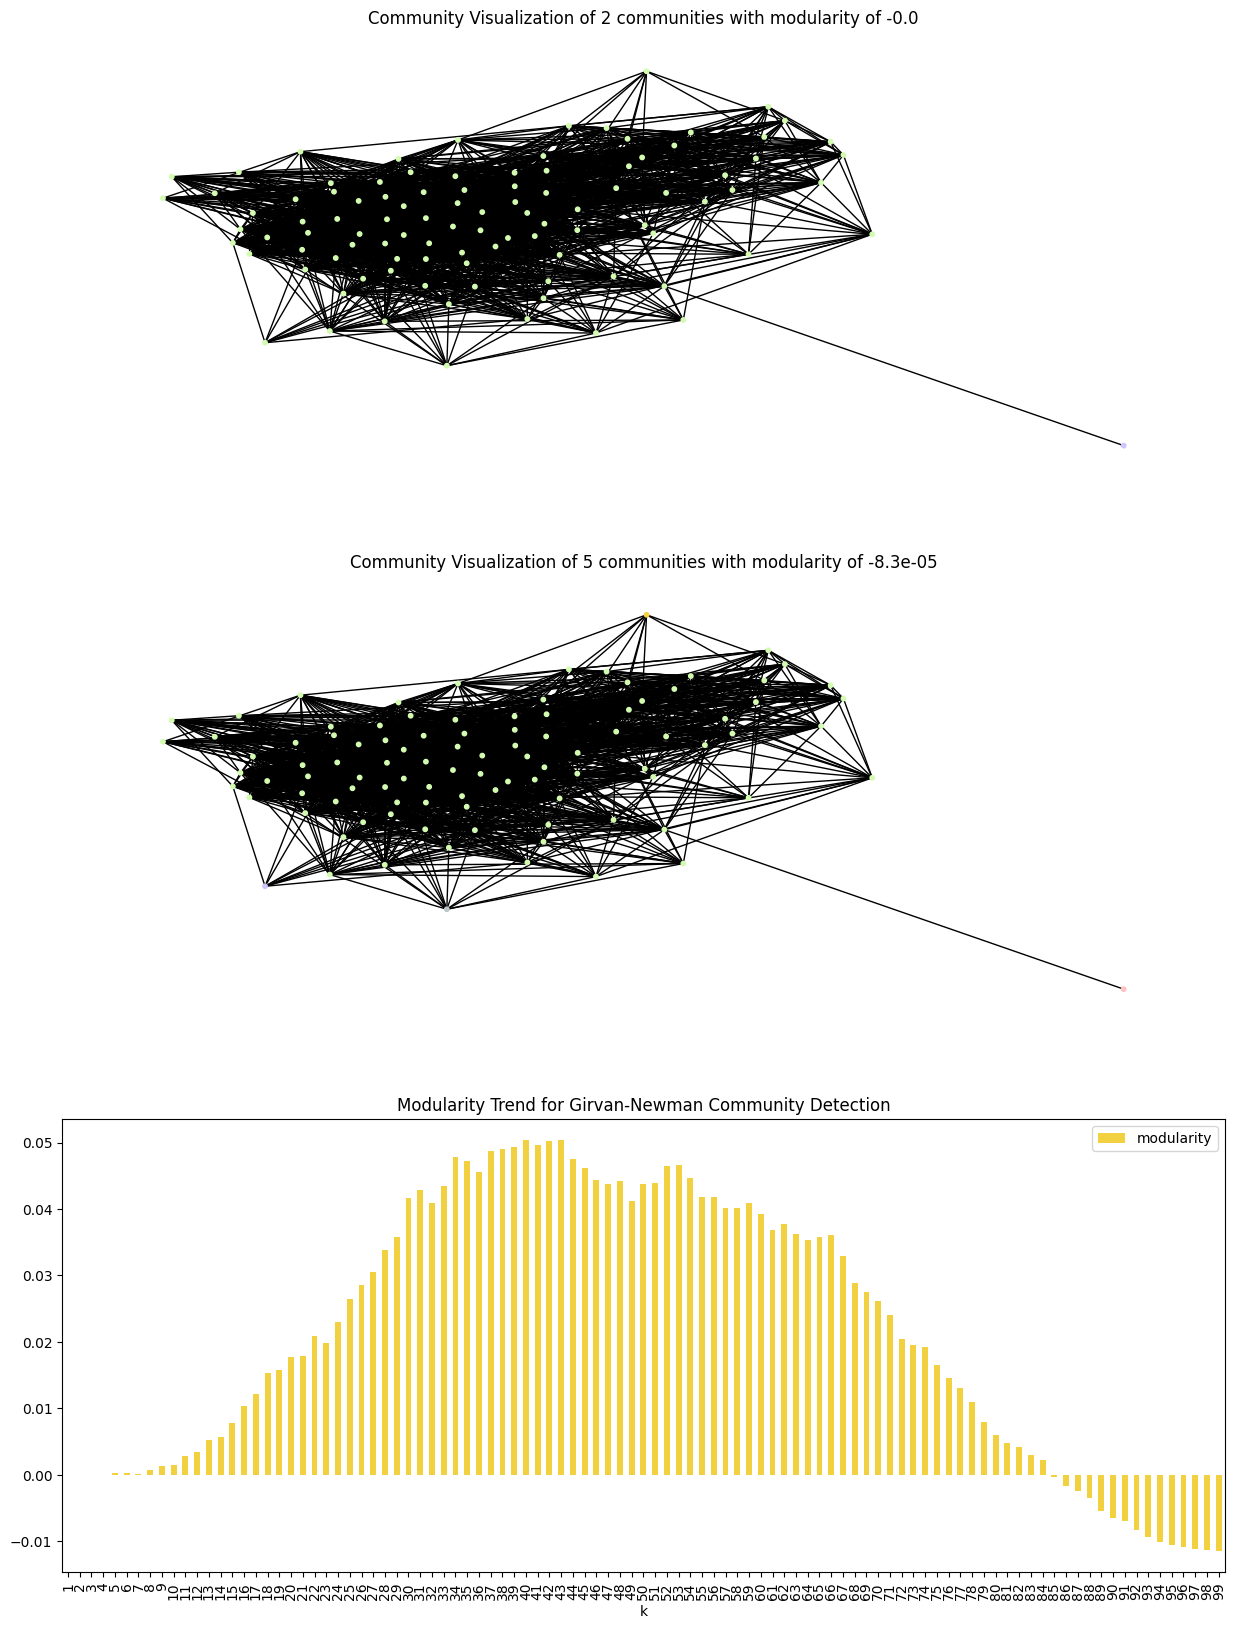

In [150]:
G = G_rf_1
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [[k + 1, nx.community.modularity(G, communities[k])] for k in range(len(communities))],
    columns=["k", "modularity"],
)

fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()

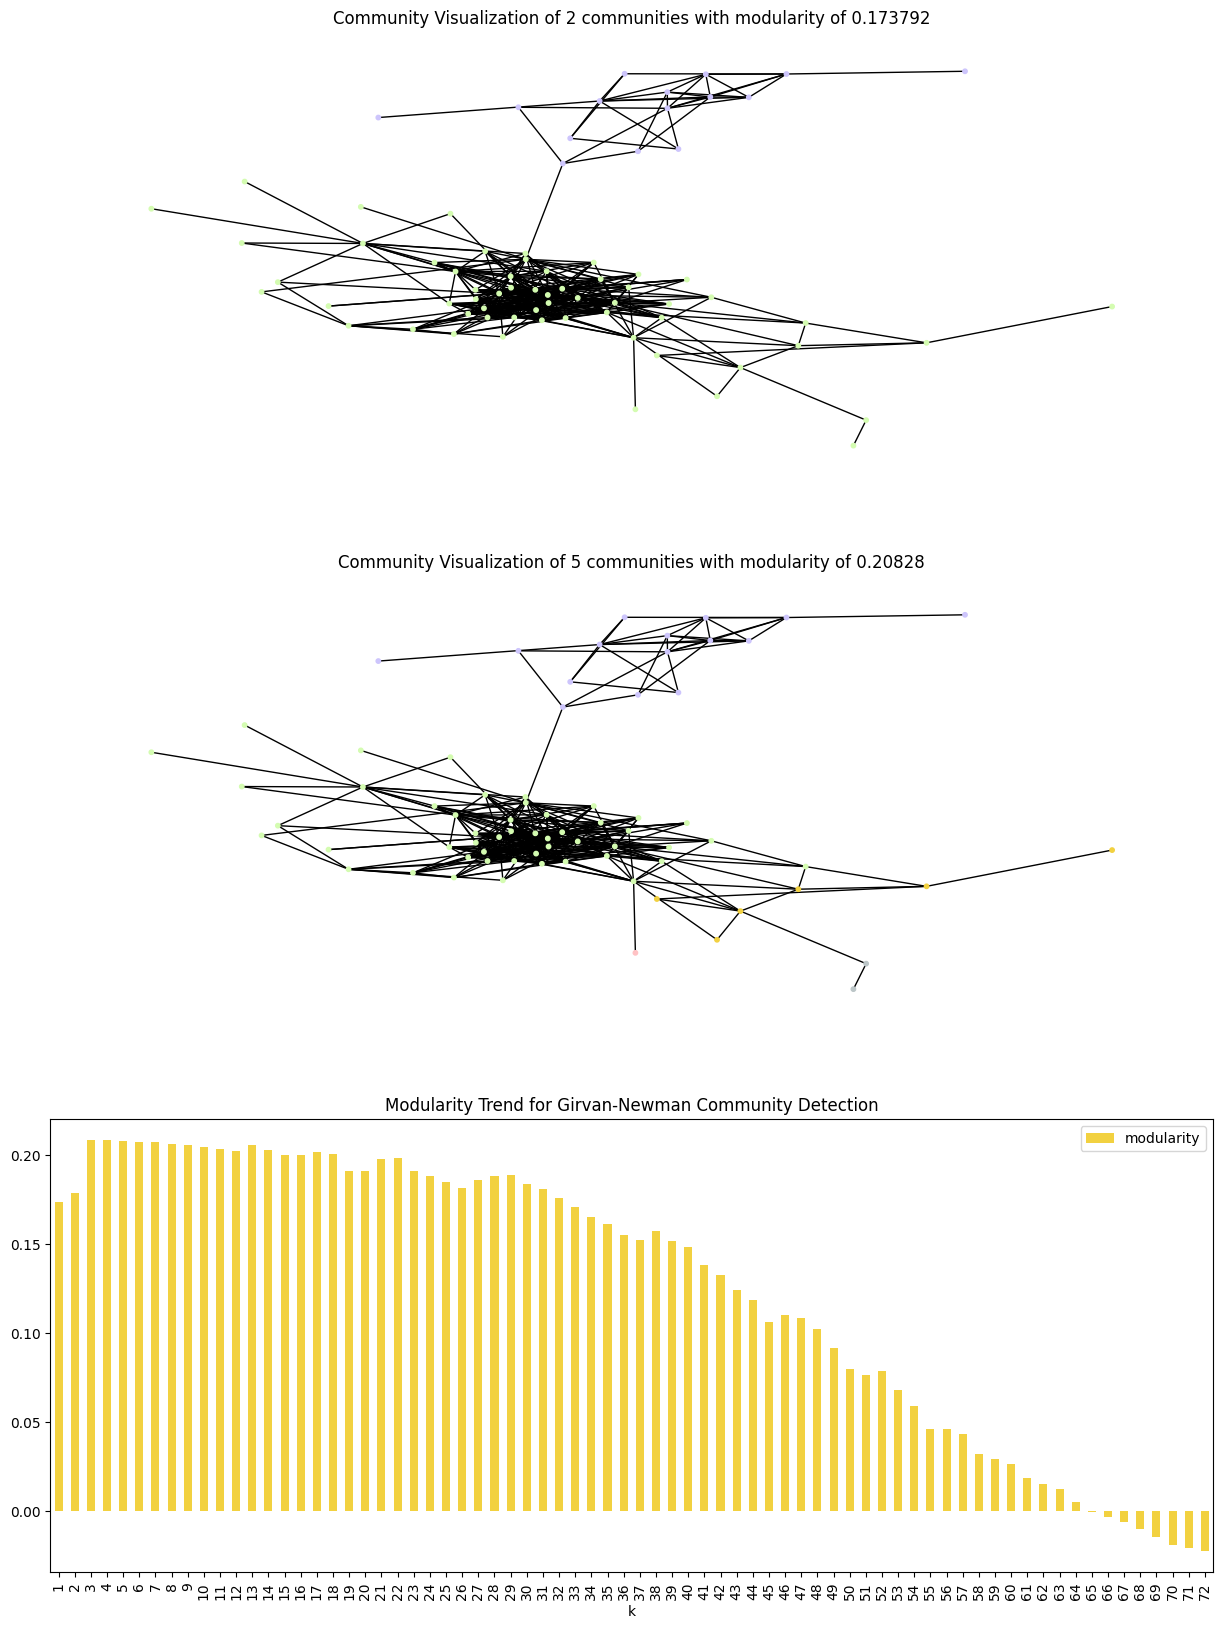

In [154]:
G = remove_degree_zero_nodes_efficient(G_rf_2)
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [[k + 1, nx.community.modularity(G, communities[k])] for k in range(len(communities))],
    columns=["k", "modularity"],
)

fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()